Credit Card Fraud Detector - by Alex Borger

Inspired by the work of Andrea Dal Pozzolo

Data by Worldline and the Machine Learning Group of the Free University of Brussels

To begin, we need to download the data from GitHub.  Alternatively, the data is publicly available from the following source:
https://www.kaggle.com/mlg-ulb/creditcardfraud

# Attention!!!

If you wish to replicate the results in this notebook, you should know:

I am running Python 3.6.8 via Anaconda.  The following packages are required:

pandas, numpy, sklearn, matplotlib (standard stuff)

keras, tensorflow (2.3.1, 2.0 respectively)

graphviz, pydotplus (these are a bit trickier... see end of notebook for full details)

In [1]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/AlexBorger/DataProjects/master/creditcard{num}.csv'

df = pd.DataFrame()
for i in range(1,7):
    df = pd.concat([df,pd.read_csv(url.format(num=i))],ignore_index=True)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,139639.0,-3.695745,3.452276,-4.440829,-1.347572,1.397759,3.891261,-2.915678,-2.237171,-0.065227,...,5.147840,-0.710243,0.827008,0.533215,-0.216667,-0.202473,-1.361741,-0.369330,5.50,0
1,139639.0,2.139768,-0.802227,-1.436458,-0.874405,-0.426319,-0.098918,-1.115957,0.157473,-0.020360,...,0.239430,0.661485,0.072373,0.067434,-0.124332,-0.105274,0.012785,-0.021729,19.99,0
2,139640.0,2.045445,-1.735290,-1.005453,-1.593744,-1.227475,-0.183185,-1.106807,-0.038946,-1.449455,...,-0.077245,-0.000323,0.203757,0.685393,-0.307420,-0.262901,-0.009653,-0.033330,119.85,0
3,139640.0,2.021652,-0.564466,-1.496431,0.688902,-0.375890,-1.128125,0.074404,-0.336272,-0.672393,...,-0.232206,-0.256491,0.081733,-0.100709,0.147291,-0.515136,-0.003192,-0.044367,67.64,0
4,139640.0,0.084695,-0.459907,0.451158,-2.774866,-1.002298,0.150489,-1.666675,-2.696009,-2.363629,...,-1.385050,0.386718,-0.156815,-0.342012,0.791022,-0.197818,0.092000,0.241003,38.00,0


The data provided has already been sanitized and reduced into 28 principal components, a time field, a transaction amount (presumably in euros) and Class: 1 for fraudulent, 0 for genuine.  The transactions occurred over a few days in September 2013.

In [2]:
# Basic descriptive stats:
print(df.columns)
print(df.iloc[:5,::5])
print(df.describe())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
       Time        V5       V10       V15       V20       V25  Class
0  139639.0  1.397759 -0.697197  0.910849 -1.653601 -0.216667      0
1  139639.0 -0.426319  0.274247 -0.177653  0.027826 -0.124332      0
2  139640.0 -1.227475  1.671403 -0.782821 -0.196871 -0.307420      0
3  139640.0 -0.375890  1.132728  0.167542 -0.669641  0.147291      0
4  139640.0 -1.002298  0.302008 -1.569565  0.332171  0.791022      0
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  4.228189e-15 -4.723485e-16 -1.097996e-14  2.688404e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
m

In [3]:
from matplotlib import pyplot as plt

plt.plot(df.Time, df.Amount)
plt.show()
print('Length of dataset: {l} rows'.format(l=len(df)))
print(df.groupby('Class').agg({'Time':len}))
print('\n Fraudulent charges are only {p}% of the examples.'.format(p=round(100*sum(df['Class'])/len(df),2)))

<Figure size 640x480 with 1 Axes>

Length of dataset: 284807 rows
           Time
Class          
0      284315.0
1         492.0

 Fraudulent charges are only 0.17% of the examples.


As you can see, the dataset is highly unbalanced.  There are 578 genuine transactions per fraudulent transaction in the dataset.  As such, we will need to manage the difference in class support with any model we use.  There is no proven way to best mitigate this issue.  This notebook will highlight the final selected methods of creating a predictive model.  The main methods that follow are weight balancing the entire training set and using a decision tree on a balanced, undersampled dataset.

Before we begin, we should make sure that our principal components are valid.  If they are valid, the principal component analysis output of these 28 columns should yield vectors pointing directly along all 28 axes (thus indicating the top 28 vectors (in n-dim space) are the axes themselves), and they should be in order.  Such a result would look (within a small tolerance) like a 28x28 identity matrix.

In [4]:
# How to prove that V1 through V28 are principal components?

from sklearn.decomposition import PCA
cols = df.columns[1:29]
pca = PCA(n_components=28)
pca.fit(df[cols])

# We need to verify that the principal components are, in fact, the 28 features provided.
# This will be evident if the results of PCA fitting point solely in the direction of each feature's axis.

for i in range(len(pca.components_)):
    if abs(np.round(pca.components_[i][i],14))!=1:
        print('Impure component found')
    else:
        print('.',end='')
        
# Furthermore, the explained variance of each component should already be in sorted order - but we will verify that this is the case.
print('\n'+str(np.round(pca.explained_variance_,4)))

# It is clear that they are in order from visual inspection, but if we are to accept more data in the future, we should be able to verify this
# in the ETL pipeline.

ev = pca.explained_variance_
delta = ev[:-1] - ev[1:] # This will subtract the next element from each element, except the last
np.all(delta == abs(delta)) # This will verify if every element in the delta array is monotonically decreasing

............................
[3.8365 2.7268 2.299  2.0047 1.9051 1.7749 1.5304 1.4265 1.207  1.1856
 1.0419 0.9984 0.9906 0.9189 0.8378 0.7678 0.7214 0.7025 0.6627 0.5943
 0.5395 0.5266 0.39   0.3668 0.2717 0.2325 0.1629 0.109 ]


True

The following cell contains a number of helper functions.  Some of them are used in the final models but others have been preserved to act solely as references.

standardize_data - Uses sklearn's StandardScaler to map data to its standard deviation (within column).

split_data - Randomly splits a dataframe into train and test features and output labels.

oversample - For a binary classification task only -- this will determine which class has a smaller support (fewer examples) and randomly sample and append repeating data to the dataframe until both classes are balanced (upsampling)

undersample - A broader classification implementation -- this will find the support of N classes and randomly sample from all classes, returning a balanced dataframe with the support of the least frequent class (downsampling)

We will not need the oversample method.  The other three will be used to represent our two final implementations:

Weighted binary classification feed forward Neural Network and random decision tree (undersampled).

In [5]:
# Option A:

# Send the existing data to a FF NN without any normalization or oversampling of fraudulent records

from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle

def standardize_data(df, avoid_cols = ['Class']):
    scaler = StandardScaler()
    for c in df.columns:
        if c in avoid_cols:
            pass
        else:
            #df[c] = normalize(scaler.fit_transform(df[[c]]))
            df[c] = scaler.fit_transform(df[[c]])
            
    return df

def split_data(df, split_frac):
    
    # This function assumes frequency of positive and negative examples are balanced.
    #print('df')
    #print(df.describe())
    
    df = shuffle(df)
    ind = round(len(df)*split_frac)
    train_x = df[:ind]
    test_x = df[ind:]
    #print('train_x')
    #print(train_x.describe())
    #print('test_x')
    #print(test_x.describe())
    
    train_y = train_x.pop('Class')
    test_y = test_x.pop('Class')
    
    print('Training examples: {0}'.format(len(train_x)))
    print('Test examples: {0}'.format(len(test_x)))
    
    return train_x, train_y, test_x, test_y

# Let's oversample!

def oversample(df, label_col = 'Class'):
    
    # For now, we assume binary classification.
    
    falses = df[df[label_col]==0]
    positives = df[df[label_col]==1]
    
    counter = 0
    
    if len(falses)==len(positives):
        print('they are the same')
        return df
    elif len(falses)<len(positives):
        print('falses are shorter')
        while len(falses)<len(positives):
            delta = len(positives) - len(falses)
            if delta < len(falses):
                falses = falses.append(falses.sample(delta))
            else:
                falses = falses.append(falses)
            counter += 1
            if counter % 10 == 0:
                print('.', end = '')
    else:
        print('positives are shorter')
        while len(positives)<len(falses):
            delta = len(falses)-len(positives)
            if delta < len(positives):
                positives = positives.append(positives.sample(delta))
            else:
                positives = positives.append(positives)
            counter += 1
            if counter % 10 == 0:
                print('.', end = '')
    print('')
    print(len(falses))
    print(len(positives))
    df = positives.append(falses)
    return df

# Undersampling

def undersample(df, label_col = 'Class'):
    supports = dict()
    classes = list(set(df[label_col]))
    classes.sort()
    for class_val in classes:
        supports[class_val] = len(df[df[label_col]==class_val])
        
    # Obtain the support size of the smallest class
    target = len(df)
    for class_val in supports:
        if supports[class_val] < target:
            target = supports[class_val]
    
    # Reduce each class to the target value with the df.sample() method
    class_results = []
    for cl in classes:
        class_results.append(df[df[label_col]==cl].sample(target))
    
    return pd.concat(class_results,ignore_index=True)


# You can swap out df_u for df_o to see the results of training on the oversampled dataset.

df_s = standardize_data(df)
#df_o = oversample(df_s)
df_u = undersample(df_s)

#train_x, train_y, test_x, test_y = split_data(df_u, 0.8)
train_x, train_y, test_x, test_y = split_data(df_s, 0.8)


# It is highly recommended to split your data BEFORE oversampling the training data, since your model will otherwise be able to see
# the same records in both sets and give the correct answer by memory.  This is not implemented here, since undersampling is the
# generally preferred method.

Using TensorFlow backend.


Training examples: 227846
Test examples: 56961


The feed forward model definition follows below.  I am using a 3 hidden layer (128, 128, 64) fully connected feed forward NN.  The hidden activations are ReLU (Rectified Linear Units) and the final activation is the sigmoid function (maps all real numbers from 0 to 1, perfect for binary classification).  The output unit undergoing the sigmoid activation is one unit between 0 and 1 and acts as the prediction for a given example.

To compensate for the unbalanced nature of this dataset, we will be using a weighted loss function:

$\sum -\alpha \mathbf{y}\log\left (\boldsymbol{\hat{y}}  \right ) - \beta \mathbf{\left ( \ 1-y \right )}\log\left (\boldsymbol{1-\hat{y}}  \right )$

For the sake of ease, we will allow beta to be 1 and adjust alpha accordingly.  We can use sklearn's compute_class_weight function to return class weights (typically a list [class 0 val, class 1 val]).  These are akin to alpha and beta respectively, so we will pass to tensorflow's weighted_cross_entropy_with_logits function a pos_weight of $\frac{\alpha}{\beta}$.

I will be using stochastic gradient descent (SGD) as the optimizer.

Update (11/10/2019):

I have implemented a much deeper network for comparison's sake.  Please see model2 for details.

Additionally, my preferred approach is to use an undersampled dataset for the NN approach.  It is much faster and produces much cleaner training results.

In [6]:
import keras.backend as K
from tensorflow import nn
from sklearn import utils as sku

weights = sku.class_weight.compute_class_weight('balanced',np.unique(df_s['Class']), df_s['Class'])
print(weights)

def weighted_loss(y_true,y_pred):
        return nn.weighted_cross_entropy_with_logits(y_true,y_pred,weights[1]/weights[0])

def get_model(df):

    model = Sequential()
    model.add(Dense(128, input_dim=len(df.columns), init="glorot_normal", activation="relu")) # glorot_normal is the Xavier initializer - avoids 0 weights
    model.add(Dense(128, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    return model

def get_model2(df): # Much deeper model

    model = Sequential()
    model.add(Dense(128, input_dim=len(df.columns), init="glorot_normal", activation="relu")) # glorot_normal is the Xavier initializer - avoids 0 weights
    model.add(Dense(128, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="glorot_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    return model

def train_unbalanced_model(model, x, y, val_split = 0.1, epochs = 5, batch_size = 128, verbose = 1):
    

    # train the model using SGD
    sgd = SGD(lr=0.01)
    model.compile(loss=weighted_loss, optimizer=sgd, metrics=["accuracy"])
    
    history = model.fit(x, y, validation_split = val_split, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model, history

def train_balanced_model(model, x, y, val_split = 0.1, epochs = 5, batch_size = 128, verbose = 1):
    

    # train the model using SGD
    sgd = SGD(lr=0.01)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])    
    history = model.fit(x, y, validation_split = val_split, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model, history

train_x.describe()

[  0.50086524 289.43800813]


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,...,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000
mean,0.000711,-0.001536,0.000956,-0.001127,-0.000254,-0.000062,-0.001070,0.001549,0.001435,0.000310,...,-0.001766,-0.000306,0.000192,0.000625,-0.001477,-0.000740,-0.000797,0.000948,-0.000657,-0.000456
std,0.999759,1.002489,1.000896,0.999981,0.999316,1.004622,1.002199,1.002202,0.993044,0.998537,...,1.001761,0.995159,0.999047,0.994225,1.000865,0.999451,0.998903,1.001065,1.013714,0.998489
min,-1.996583,-28.798555,-44.035292,-31.871733,-4.013919,-82.408097,-19.636058,-33.551923,-61.302524,-12.228015,...,-70.691461,-47.419067,-13.090009,-58.716406,-4.683638,-16.683307,-5.401098,-24.515522,-46.746117,-0.353229
25%,-0.855091,-0.471508,-0.362060,-0.587989,-0.598781,-0.499364,-0.576609,-0.446901,-0.174926,-0.584430,...,-0.274524,-0.311055,-0.748121,-0.258764,-0.586994,-0.609178,-0.677995,-0.175827,-0.160623,-0.331040
50%,-0.212208,0.007511,0.040266,0.118666,-0.013669,-0.039113,-0.206780,0.032506,0.018814,-0.046542,...,-0.081166,-0.040601,0.009942,-0.017901,0.067326,0.029618,-0.108951,0.003084,0.033801,-0.265271
75%,0.937775,0.671549,0.488193,0.676376,0.525881,0.443510,0.296922,0.461115,0.274461,0.542054,...,0.172722,0.253619,0.728329,0.236650,0.724597,0.672701,0.497529,0.226345,0.237429,-0.045227
max,1.642058,1.253351,13.000139,2.787207,11.918743,25.214135,55.020149,97.478239,16.751534,9.459861,...,49.443558,37.034714,14.473041,35.364272,7.569684,14.425318,7.293975,78.319397,102.543421,102.362243


Below is the function get_report.  With a model's final weights, a log of metrics during training and test data, this function will present multiple valuable model performance indicators, including:

Accuracy - the total fraction of correct predictions in the test set (assuming a threshold of 50% likelihood)

Precision - the total fraction of positive predictions that are true positives (how many fraud detections were fraud)

Recall - the total fraction of true positives that were positive predictions (how many frauds did we properly detect)

F1 score - calculated as 

$2 * \frac{\boldsymbol{P*R}}{\boldsymbol{P+R}}$

where P is precision and R is recall.

Confusion matrix:

$\begin{vmatrix}
TN & FP\\ 
FN & TP
\end{vmatrix}$

T - True, F - False, N - Negative, P - Positive

Given the nature of our task, we would like to reduce False Negatives as much as possible, since every FN costs the bank dearly (cost of transaction, labor and potential customer churn).  It can be assumed that the cost of a False Positive is considerably less than that of a FN.  As a result, we will use recall as our primary model performance indicator.

In [7]:
import sklearn.metrics as skm

def get_report(model, history, test_x, test_y):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Losses')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Cross Val'], loc='upper left')
    plt.show()

    loss, accuracy = model.evaluate(test_x, test_y)
    
    # predict probabilities for test set
    yhat_probs = model.predict(test_x, verbose=0)
    # predict crisp classes for test set
    yhat_classes = model.predict_classes(test_x, verbose=0)
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]
     
    # accuracy: (tp + tn) / (p + n)
    accuracy = skm.accuracy_score(test_y, yhat_classes)
    print('Accuracy: {0}'.format(accuracy))
    # precision tp / (tp + fp)
    precision = skm.precision_score(test_y, yhat_classes)
    print('Precision: {0}'.format(precision))
    # recall: tp / (tp + fn)
    recall = skm.recall_score(test_y, yhat_classes)
    print('Recall: {0}'.format(recall))
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = skm.f1_score(test_y, yhat_classes)
    print('F1 score: %f' % f1)
 
    # ROC AUC
    #auc = skm.roc_auc_score(test_y, yhat_probs)
    #print('ROC AUC: %f' % auc)
    
    # AUPRC
    precision, recall, thresh = skm.precision_recall_curve(test_y, yhat_probs)
    #print('AUPRC: precision: {p}\n recall: {r}\n threshold: {t}'.format(p=precision,r=recall,t=thresh))
    auprc = skm.average_precision_score(test_y, yhat_probs)
    print('AUPRC: {0}'.format(auprc))
    plt.figure()
    plt.plot(thresh, precision[:-1])
    plt.plot(thresh, recall[:-1])
    plt.legend(['Precision','Recall'])
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.show()
    
    
    # confusion matrix
    matrix = skm.confusion_matrix(test_y, yhat_classes)
    print(matrix)
    
    print('The highest fraud likelihood measured was {0}.'.format(max(yhat_probs)))

Now that we've defined our model, let's fit our model on our standardized training data.  We'll use a batch size of 64 examples (speeding up the calculations through the layers of the network by using vectorized formulas).  We'll also run this through our training set 40 times.

Note:  If your computer is taking a while to compute these calculations, feel free to change the batch_size value to 128 or 256 and decrease the number of epochs.

Training examples: 787
Test examples: 197
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (D

C:\Users\Alex\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=30, activation="relu", kernel_initializer="glorot_normal")`


Train on 708 samples, validate on 79 samples
Epoch 1/120
708/708 [==============================] - 0s 361us/step - loss: 0.8053 - accuracy: 0.4972 - val_loss: 0.6978 - val_accuracy: 0.5190
Epoch 2/120
708/708 [==============================] - 0s 32us/step - loss: 0.7477 - accuracy: 0.4986 - val_loss: 0.6888 - val_accuracy: 0.6076
Epoch 3/120
708/708 [==============================] - 0s 31us/step - loss: 0.7274 - accuracy: 0.4534 - val_loss: 0.6808 - val_accuracy: 0.6709
Epoch 4/120
708/708 [==============================] - 0s 32us/step - loss: 0.7106 - accuracy: 0.4816 - val_loss: 0.6776 - val_accuracy: 0.5823
Epoch 5/120
708/708 [==============================] - 0s 31us/step - loss: 0.6999 - accuracy: 0.4887 - val_loss: 0.6737 - val_accuracy: 0.5823
Epoch 6/120
708/708 [==============================] - 0s 30us/step - loss: 0.6913 - accuracy: 0.4958 - val_loss: 0.6706 - val_accuracy: 0.5949
Epoch 7/120
708/708 [==============================] - 0s 30us/step - loss: 0.6892 - accur

708/708 [==============================] - 0s 30us/step - loss: 0.2236 - accuracy: 0.9308 - val_loss: 0.1805 - val_accuracy: 0.9367
Epoch 58/120
708/708 [==============================] - 0s 30us/step - loss: 0.2202 - accuracy: 0.9379 - val_loss: 0.1772 - val_accuracy: 0.9367
Epoch 59/120
708/708 [==============================] - 0s 30us/step - loss: 0.2333 - accuracy: 0.9237 - val_loss: 0.1742 - val_accuracy: 0.9367
Epoch 60/120
708/708 [==============================] - 0s 30us/step - loss: 0.2241 - accuracy: 0.9280 - val_loss: 0.1719 - val_accuracy: 0.9367
Epoch 61/120
708/708 [==============================] - 0s 28us/step - loss: 0.2144 - accuracy: 0.9379 - val_loss: 0.1697 - val_accuracy: 0.9367
Epoch 62/120
708/708 [==============================] - 0s 31us/step - loss: 0.2259 - accuracy: 0.9209 - val_loss: 0.1673 - val_accuracy: 0.9367
Epoch 63/120
708/708 [==============================] - 0s 30us/step - loss: 0.1990 - accuracy: 0.9393 - val_loss: 0.1644 - val_accuracy: 0.936

708/708 [==============================] - 0s 30us/step - loss: 0.1301 - accuracy: 0.9576 - val_loss: 0.1621 - val_accuracy: 0.9367
Epoch 114/120
708/708 [==============================] - 0s 28us/step - loss: 0.1316 - accuracy: 0.9605 - val_loss: 0.1794 - val_accuracy: 0.9367
Epoch 115/120
708/708 [==============================] - 0s 30us/step - loss: 0.1660 - accuracy: 0.9449 - val_loss: 0.1580 - val_accuracy: 0.9494
Epoch 116/120
708/708 [==============================] - 0s 31us/step - loss: 0.1665 - accuracy: 0.9492 - val_loss: 0.1499 - val_accuracy: 0.9494
Epoch 117/120
708/708 [==============================] - 0s 30us/step - loss: 0.1397 - accuracy: 0.9548 - val_loss: 0.1450 - val_accuracy: 0.9367
Epoch 118/120
708/708 [==============================] - 0s 30us/step - loss: 0.1408 - accuracy: 0.9590 - val_loss: 0.1430 - val_accuracy: 0.9367
Epoch 119/120
708/708 [==============================] - 0s 30us/step - loss: 0.1361 - accuracy: 0.9562 - val_loss: 0.1330 - val_accuracy:

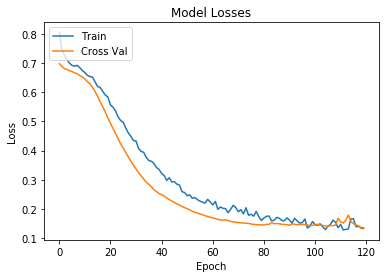

197/197 [==============================] - 0s 51us/step
Accuracy: 0.949238578680203
Precision: 0.9787234042553191
Recall: 0.92
F1 score: 0.948454
AUPRC: 0.9945870658189607


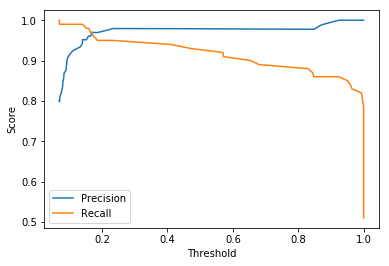

[[95  2]
 [ 8 92]]
The highest fraud likelihood measured was 1.0.


In [9]:
train_x, train_y, test_x, test_y = split_data(df_u, 0.8)
model = get_model2(train_x)
print(model.summary())
model, history = train_balanced_model(model, train_x, train_y, epochs = 120, batch_size=64)

get_report(model, history, test_x, test_y)

If you ran the model on unsampled data:

Based on these results, you will likely see a very high accuracy, decent recall, bad F1 score and terrible precision.  This is fine!  Keep in mind we've told the network to treat a false negative much harsher than a false positive in order to balance the training weight updates.  This only prevents the network from having its weight updates dominated by the majority class.  It does not prevent the model from being wrong!  Especially considering the fact that we have 578 genuine transactions for every fraudulent one, it's highly unlikely to expect the model to have the same frequency of false negatives as false positives.

A helpful metric that can give more insight into this is the specificity score (sister metric of recall), which represents the fraction of true negatives that were predicted negative.  For this case, since our confusion matrix result was:

$\begin{vmatrix}
56674 & 196\\ 
12 & 79
\end{vmatrix}$

The specificity score is 0.9966, meaning only 0.34% of all genuine transactions were flagged as fraudulent by our model.  In the real world, this would be manageable over a two day period (the rough timeframe of this dataset) for a team of investigators.  A handful of cases would be resolved fairly quickly (and possible automatically and/or by the hand of the customer), so one could expect far fewer than 100 manual investigations per day.

If you ran the model on undersampled data (this notebook uses undersampled):

The results with undersampling are quite nice!  From one specific training session, we achieved 92% recall and 97.9% precision.  AUPRC is 0.995.  As we will see later on, this is comparable, if not slightly preferred to our traditional approach.

$\begin{vmatrix}
95 & 2\\ 
8 & 92
\end{vmatrix}$


While this method seems to work fine, let's take a look at a more traditional approach next.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df_u = undersample(df_s) # recalculate df_u
train_x, train_y, test_x, test_y = split_data(df_u, 0.8)

# train model
rf = RandomForestClassifier(n_estimators=600, min_samples_leaf=1).fit(train_x, train_y)

# predict on test set
rf_pred = rf.predict(test_x)

print(confusion_matrix(test_y,rf_pred))
print(classification_report(test_y,rf_pred))
print(accuracy_score(test_y,rf_pred))



Training examples: 787
Test examples: 197
[[92  0]
 [12 93]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        92
           1       1.00      0.89      0.94       105

   micro avg       0.94      0.94      0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197

0.9390862944162437


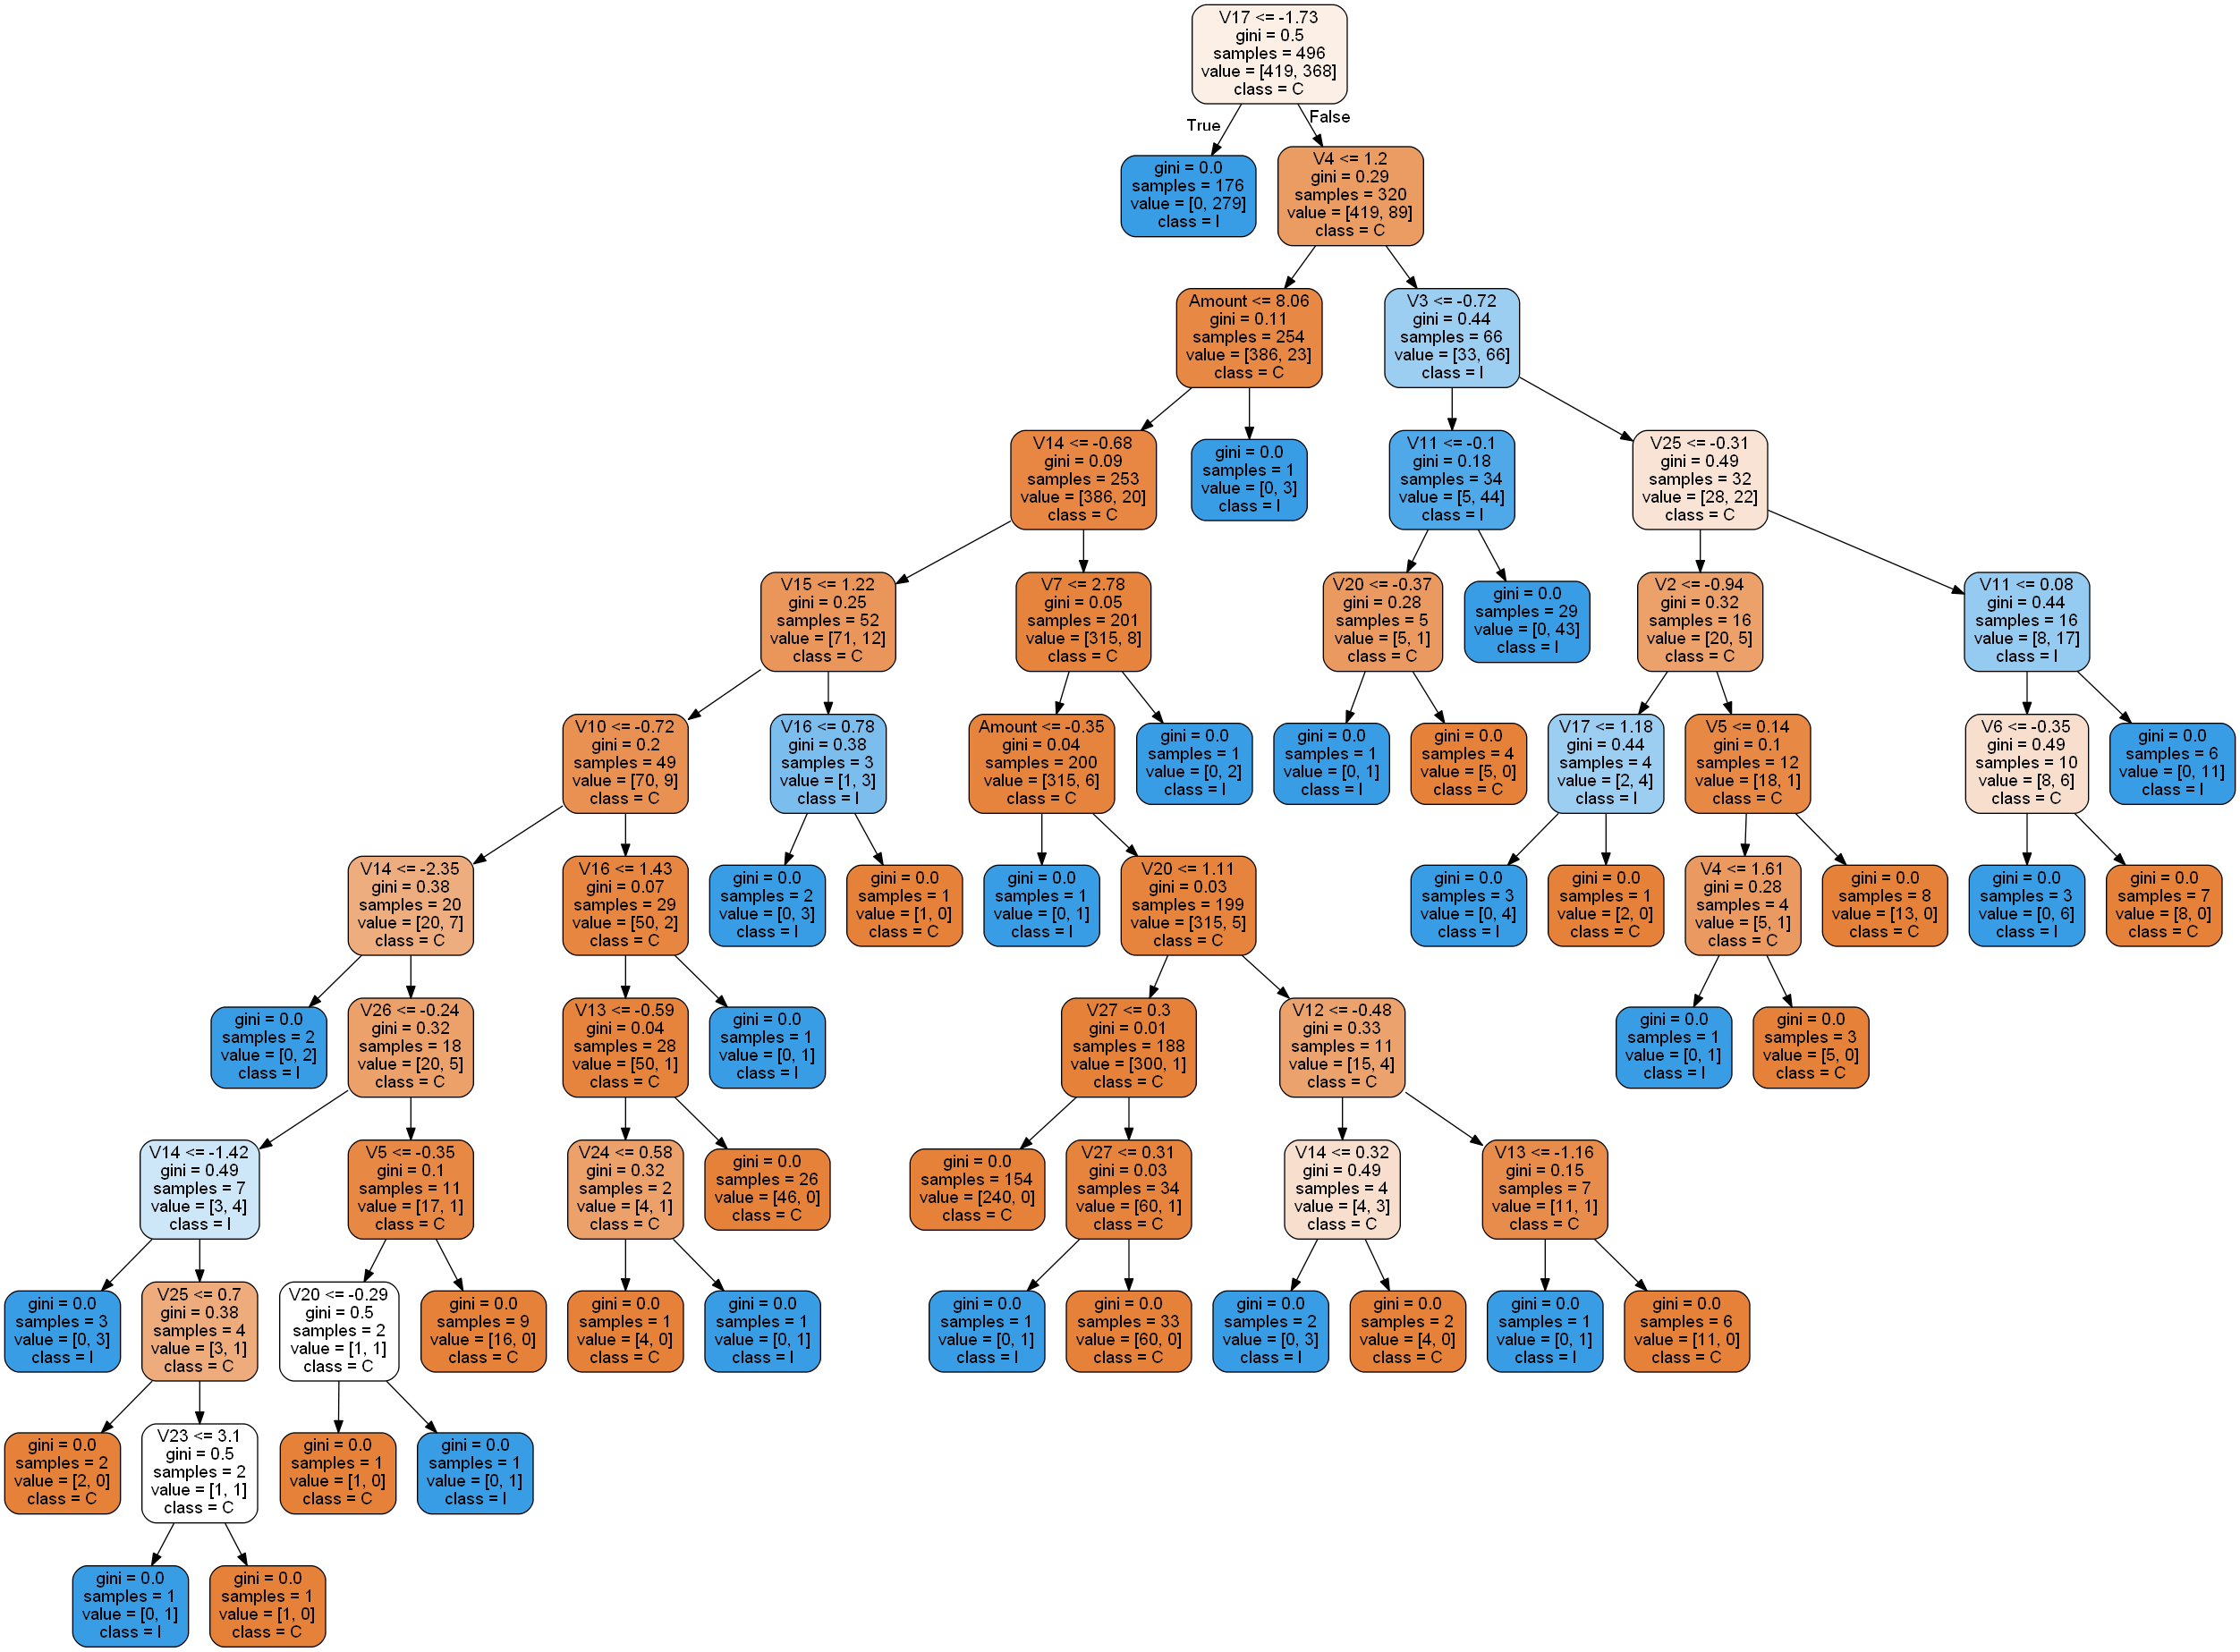

In [11]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
# Export as dot file
export_graphviz(rf.estimators_[0], out_file='tree.dot', 
                feature_names = train_x.columns,
                class_names = train_y.name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

pydot_graph = pydotplus.graph_from_dot_file("tree.dot")
Image(pydot_graph.create_png())


For this decision tree model, we are using an undersampling of our original dataset (with standardization applied) in order to balance the classes.  Decision trees can have a tendency to ignore tiny clusters of data in favor of more generalizing splits (essentially if-else blocks).  This can hurt a very unbalanced dataset because those tiny clusters could have been fraudulent charges and blending them with their neighboring cluster of data could prevent the model from working at all.

This tree had a decent confusion matrix result:

$\begin{vmatrix}
103 & 4\\ 
7 & 83
\end{vmatrix}$

Remember, these results are on the test data from our undersampled dataset, so the total support is much smaller.

In the end, both models work relatively well - recall above 90% and transaction evaluation time is only a fraction of a second.  Both models would benefit from having more data.  Unfortunately it seems to be a catch 22 - if you want to prevent fraudulent charges, you need to record more fraudulent charges in order to know how to prevent them!  Nevertheless, having a robust fraud detection model can only improve existing systems.  Even with a lower alert threshold (below 50%), you can attain much better results than you could by using "hunch" logic flows.


If you found this material interesting, I highly recommend you check out some of the highly regarded, publicly available Kaggle kernels for this topic: https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels?sortBy=voteCount&group=everyone&pageSize=20&datasetId=310

There are many great ideas present in their work, and they certainly surpass the level of expertise and knowledge present in this notebook!

I also recommend you check out the original thesis by Andrea Dal Pozzolo, whom without we would not have this dataset:
https://dalpozz.github.io/static/pdf/Dalpozzolo2015PhD.pdf


If you've made it to the end of this notebook, I would like to say:

Thanks very much for reading!  I hope you enjoyed this notebook and found some useful tidbits and factoids!

If you are interested in any of my other work, feel free to check out my GitHub here:  https://github.com/AlexBorger/DataProjects

Or if you wanted to know more about my experience, please visit my LinkedIn page:
https://www.linkedin.com/in/alex-borger/



# Bonus - Presentation Visualizations

C:\Users\Alex\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Alex\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


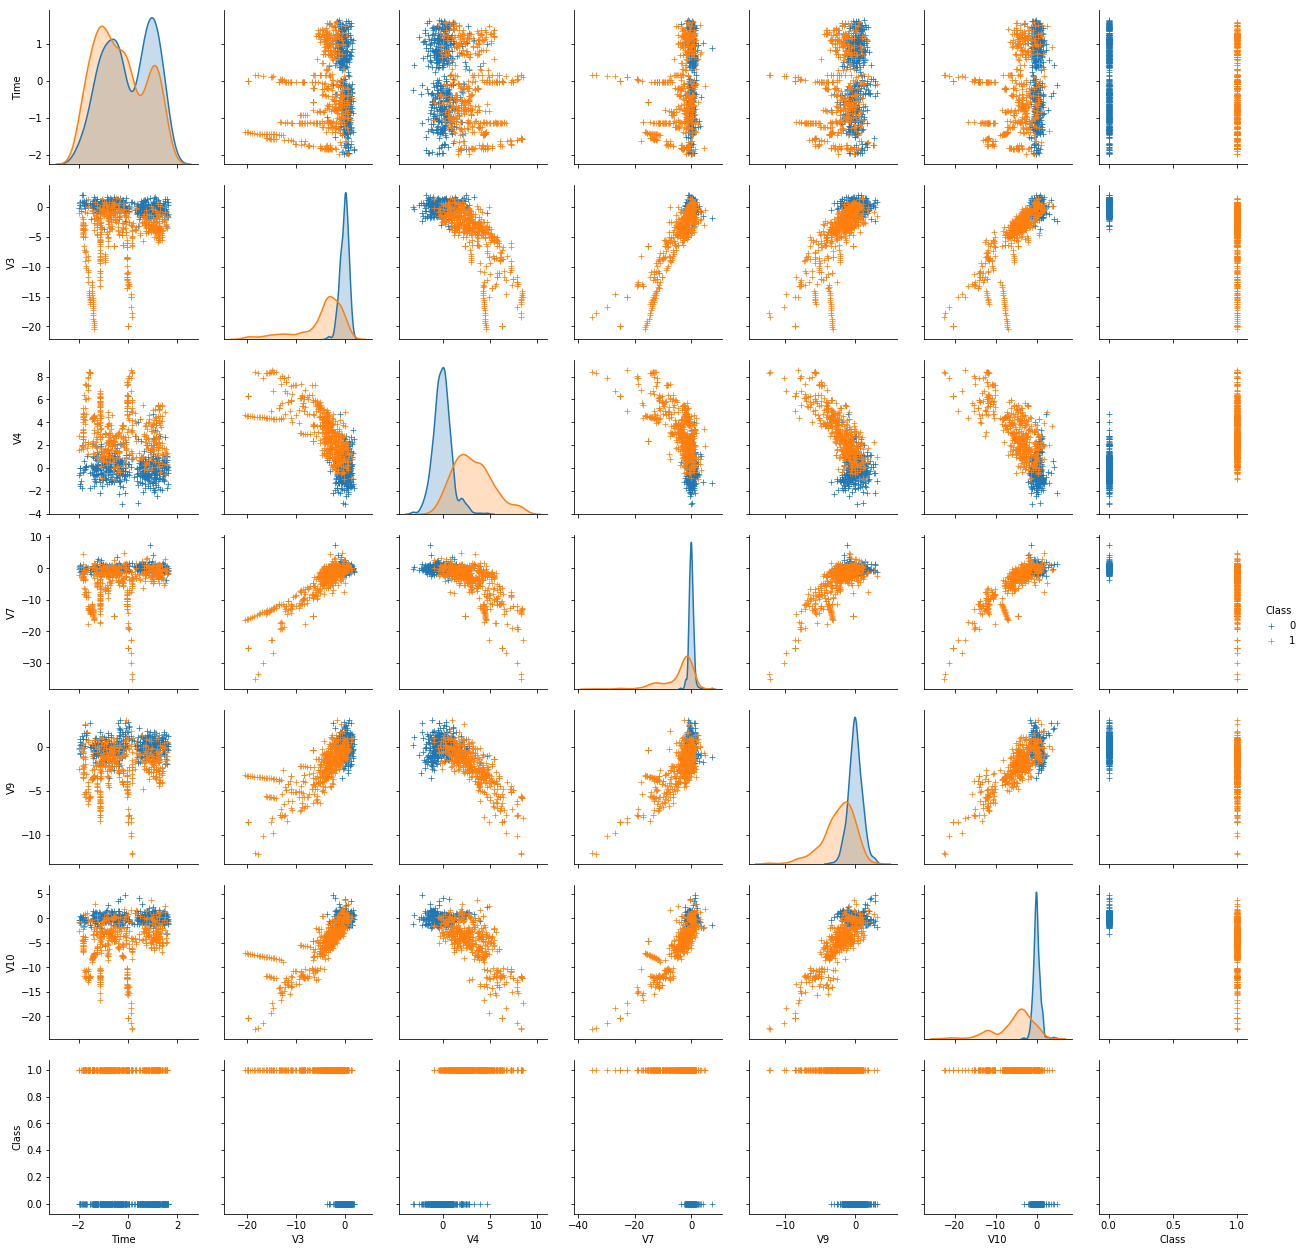

In [12]:
import seaborn as sns

under = undersample(df)

# Which columns are most appealing?
#sns.pairplot(under[['Time','Amount','V1','V2','V3','V4','V5','V6','V7','V8','Class']], hue = 'Class', markers = '+')
#sns.pairplot(under[['Time','Amount','V9','V10','V11','V12','V13','V14','V15','V16','Class']], hue = 'Class', markers = '+')
#sns.pairplot(under[['Time','Amount','V17','V18','V19','V20','V21','V22','V23','V24','Class']], hue = 'Class', markers = '+')
#sns.pairplot(under[['Time','Amount','V25','V26','V27','V28','Class']], hue = 'Class', markers = '+')

# These ones!
sns.pairplot(under[['Time','V3','V4','V7','V9','V10','Class']], hue = 'Class', markers = '+')

Text(0.5, 1.0, 'Timestamps (in seconds from start date)')

<Figure size 432x288 with 0 Axes>

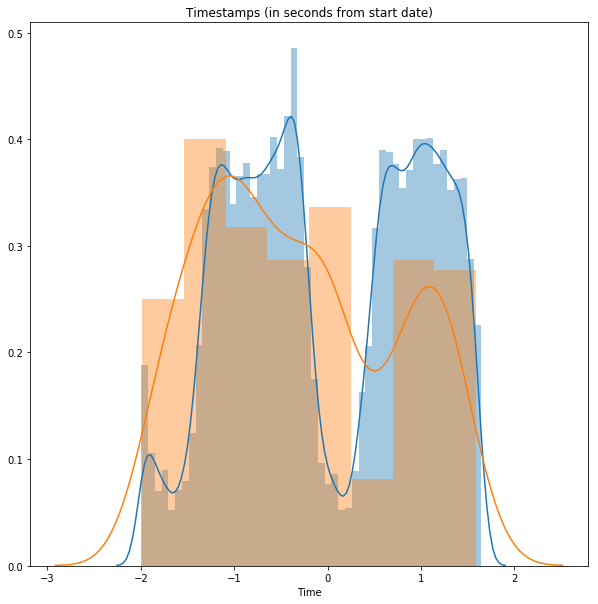

In [13]:
#plt.hist(under['Time'],bins=200)
plt.figure()
plt.subplots(figsize=(10,10))
sns.distplot(df[df['Class']==0]['Time'])#, kde = False)
sns.distplot(df[df['Class']==1]['Time'])#, kde = False)
plt.title('Timestamps (in seconds from start date)')


In [15]:
sums = pd.DataFrame()

for col in df.columns:
    sums = sums.append({'Column':col,'Min':df[col].min(),'Max':df[col].max(),'Avg':df[col].mean()},ignore_index=True)
    
sums

,Avg,Column,Max,Min
0,5.841159e-14,Time,1.642058,-1.996583
1,-1.262048e-15,V1,1.253351,-28.798555
2,-1.468682e-16,V2,13.357750,-44.035292
3,-1.267585e-15,V3,6.187993,-31.871733
4,-1.058333e-15,V4,11.918743,-4.013919
5,-2.125113e-16,V5,25.214135,-82.408097
6,-1.614279e-16,V6,55.020149,-19.636058
7,3.451820e-19,V7,97.478239,-35.209396
8,-3.436839e-16,V8,16.751534,-61.302524
9,3.149494e-16,V9,14.194945,-12.228015


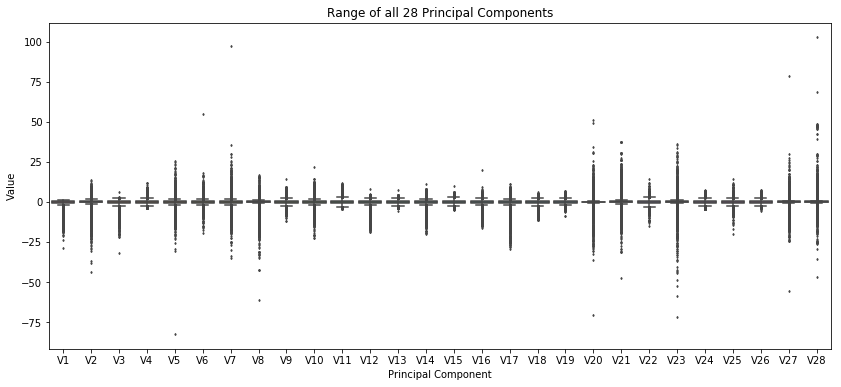

In [16]:
plt.figure(figsize=(14,6))
sns.boxplot(x="variable", y="value", data=pd.melt(df.drop(['Time','Amount','Class'],axis=1)),fliersize=1.5)
plt.xlabel('Principal Component')
plt.ylabel('Value')
plt.title('Range of all 28 Principal Components')
plt.show()

C:\Users\Alex\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=30, activation="relu", kernel_initializer="glorot_normal")`


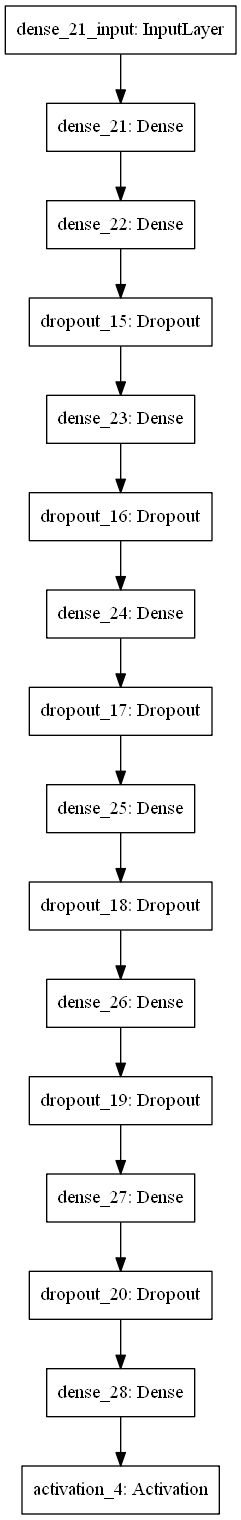

In [18]:
from keras.utils import plot_model
model = get_model2(train_x)
plot_model(model)

# GraphViz and PyDotPlus Installation

There is a known issue with graphviz and pydot - hopefully this stackoverflow page will have a working solution for your build: https://stackoverflow.com/questions/28312534/graphvizs-executables-are-not-found-python-3-4

In my case, I had to go into the keras file vis_utils.py and edit the import call to pydot as follows:

Original:

import pydot

Edited:

import pydotplus as pydot

The cell below will show you exactly where that vis_utils.py file is in your system.

Hopefully this is enough instruction to get pydotplus's keras model visuals to work on your build.

In [28]:
from keras.utils import plot_model
??plot_model

In [20]:
from platform import python_version

print(python_version())

3.6.8


In [23]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [27]:
import keras
print(keras.__version__)

2.3.1
